In [57]:
import requests
import pandas as pd
import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# OKX API Á´ØÁÇπ
BASE_URL = "https://www.okx.com/api/v5"

def get_okx_klines(instId="ETH-USDT", bar="1D", limit=101):
    url = f"{BASE_URL}/market/candles"
    params = {"instId": instId, "bar": bar, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()

    if "data" in data:
        df = pd.DataFrame(data["data"], columns=[
            "timestamp", "open", "high", "low", "close", "volume", "volCcy", "vol", "trades"
        ])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("timestamp", inplace=True)
        df = df.astype(float)
        return df
    else:
        print("‚ùå Ëé∑ÂèñÊï∞ÊçÆÂ§±Ë¥•:", data)
        return None

# ‰∫§ÊòìÂØπÂàóË°®
symbols = ["BTC-USDT", "ETH-USDT", "SOL-USDT", "BNB-USDT", "XRP-USDT", "ADA-USDT", "DOGE-USDT", "DOT-USDT"]
data_dict = {}
W1 = []
W2 = []
actual_portfolio_return1 = []
actual_portfolio_return2 = []

for kkk in tqdm(range(10)):
        # Ëé∑ÂèñÊâÄÊúâ‰∫§ÊòìÂØπÊï∞ÊçÆ
    for symbol in symbols:
        df = get_okx_klines(symbol, "1D", 101)
        if df is not None:
            data_dict[symbol] = df["close"]
    
    # ÁªÑÂêàÊàê DataFrame
    market_data = pd.DataFrame(data_dict)
    market_data.dropna(inplace=True)
    returns = market_data.pct_change().dropna()
    train_data = returns.iloc[:-1]  # Ââç 100 Â§©ÁöÑÊî∂ÁõäÊï∞ÊçÆ
    test_data = returns.iloc[-1:]  # ‰ªÖÊúÄÂêé‰∏ÄÂ§©ÁöÑÊï∞ÊçÆ
    test_data = test_data.to_numpy().reshape(-1, 1)
    
    # **‰øÆÂ§ç `reshape` ÈîôËØØ**
    expected_returns = np.mean(train_data, axis=0).to_numpy().reshape(-1, 1)  # **ËΩ¨Êç¢‰∏∫ NumPy**
    cov_matrix = np.cov(train_data.T) + 1e-6 * np.eye(len(symbols))
    
    # ÂÆö‰πâ‰ºòÂåñÂèòÈáèÔºàËµÑ‰∫ßÊùÉÈáçÔºâ
    W = cp.Variable((len(symbols), 1))  # Á°Æ‰øùÊòØÂàóÂêëÈáè
    
    # ÁõÆÊ†áÂáΩÊï∞ÔºöÊúÄÂ§ßÂåñÊî∂Áõä - È£éÈô©
    risk_aversion = 0.5
    objective = cp.Maximize(cp.matmul(expected_returns.T, W) - risk_aversion * cp.quad_form(W, cov_matrix))
    
    # Á∫¶ÊùüÊù°‰ª∂
    constraints = [
        cp.sum(W) == 0,
        W >= -1,
        W <= 1,
    ]
    
    # Ê±ÇËß£‰ºòÂåñÈóÆÈ¢ò
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    # ËæìÂá∫‰ºòÂåñÁªìÊûú
    if problem.status not in ["infeasible", "unbounded"]:
        print("\nüìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:")
        for i, symbol in enumerate(symbols):
            print(f"{symbol}: {W.value[i][0]:.4f}")
    else:
        print("‚ùå ‰ºòÂåñÈóÆÈ¢òÊó†Ëß£")
    
    W1.append(W)
    
    # **üöÄ 1. Êú∫Âô®Â≠¶‰π†È¢ÑÊµãÊî∂ÁõäÔºà‰ºòÂåñ LSTMÔºâ**
    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
            super(LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
    
        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            return self.fc(out[:, -1, :])
    
    def predict_lstm(series):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
        seq_length = 50 
        X, y = [], []
        for i in range(len(scaled_data) - seq_length - 1):
            X.append(scaled_data[i:i + seq_length])
            y.append(scaled_data[i + seq_length])
    
        X, y = np.array(X), np.array(y)
        X = X.reshape(X.shape[0], X.shape[1], 1)  # **Á°Æ‰øù LSTM ËæìÂÖ•ÂΩ¢Áä∂Ê≠£Á°Æ**
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # **y ‰πüË¶Å reshape**
    
        # 80% ËÆ≠ÁªÉÔºå20% ÊµãËØï
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
    
        model = LSTMModel()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        best_loss = float("inf")
        best_model_state = None
    
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)  # **Á°Æ‰øùËæìÂÖ•ÊòØ 3D**
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
    
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = model.state_dict().copy()
    
        model.load_state_dict(best_model_state)
    
        # È¢ÑÊµã‰∏ã‰∏ÄÊ≠•
        with torch.no_grad():
            X_pred = torch.tensor(scaled_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)
            future_pred = model(X_pred).detach().numpy()
    
        return scaler.inverse_transform(future_pred)[0][0]
    
    expected_returns = np.mean(train_data, axis=0).to_numpy().reshape(-1, 1)  # **ËΩ¨Êç¢‰∏∫ NumPy**
    cov_matrix = np.cov(train_data.T) + 1e-6 * np.eye(len(symbols))
    predicted_returns = np.array([predict_lstm(train_data[symbol]) for symbol in symbols]).reshape(-1, 1)
    
    
    # **üöÄ 3. ‰º†ÁªüÂùáÂÄº-ÊñπÂ∑Æ‰ºòÂåñ**
    W = cp.Variable((len(symbols), 1))
    risk_aversion = 1
    
    objective = cp.Maximize(cp.matmul((0.8*expected_returns + 0.2*predicted_returns).T, W) - risk_aversion * cp.quad_form(W, cov_matrix))
    constraints = [cp.sum(W) == 0, W >= -1, W <= 1]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    # **üöÄ 6. ËæìÂá∫‰ºòÂåñÁªìÊûú**
    
    # ËæìÂá∫‰ºòÂåñÁªìÊûú
    if problem.status not in ["infeasible", "unbounded"]:
        print("\nüìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:")
        for i, symbol in enumerate(symbols):
            print(f"{symbol}: {W.value[i][0]:.4f}")
    else:
        print("‚ùå ‰ºòÂåñÈóÆÈ¢òÊó†Ëß£")
    
    W2.append(W) 
    actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
    actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
    

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8576
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8575
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 10%|‚ñà         | 1/10 [00:10<01:31, 10.19s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: 1.0000
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -0.9044
ADA-USDT: -0.9116
DOGE-USDT: 1.0000
DOT-USDT: 0.8160


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8555
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8555
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 20%|‚ñà‚ñà        | 2/10 [00:20<01:20, 10.05s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 0.7220
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -0.9301
ADA-USDT: -0.7918
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8570
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8569
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 30%|‚ñà‚ñà‚ñà       | 3/10 [00:30<01:10, 10.09s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -0.7773
ETH-USDT: 1.0000
SOL-USDT: -0.1080
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.1147
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8552
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8551
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 40%|‚ñà‚ñà‚ñà‚ñà      | 4/10 [00:40<01:01, 10.18s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: 0.3607
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.3606
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8510
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8510
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 5/10 [00:51<00:51, 10.28s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -0.2652
XRP-USDT: -1.0000
ADA-USDT: 0.8167
DOGE-USDT: 1.0000
DOT-USDT: 0.4485


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8517
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8517
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 6/10 [01:01<00:41, 10.27s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -1.0000
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8501
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8501
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 7/10 [01:12<00:31, 10.44s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: 1.0000
ETH-USDT: -0.8095
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: 0.8094
DOGE-USDT: 1.0000
DOT-USDT: -1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8515
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8515
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 8/10 [01:22<00:20, 10.46s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: 0.4996
ETH-USDT: 1.0000
SOL-USDT: -1.0000
BNB-USDT: -0.7846
XRP-USDT: -0.9386
ADA-USDT: -0.7764
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8530
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8530
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 9/10 [01:32<00:10, 10.39s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 1.0000
BNB-USDT: -0.5859
XRP-USDT: -1.0000
ADA-USDT: 0.5859
DOGE-USDT: 1.0000
DOT-USDT: -1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8508
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8508
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [01:42<00:00, 10.30s/it]


üìà ÊúÄ‰ºò‰∫§ÊòìÂØπÊùÉÈáçÂàÜÈÖç:
BTC-USDT: 0.8643
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8643
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


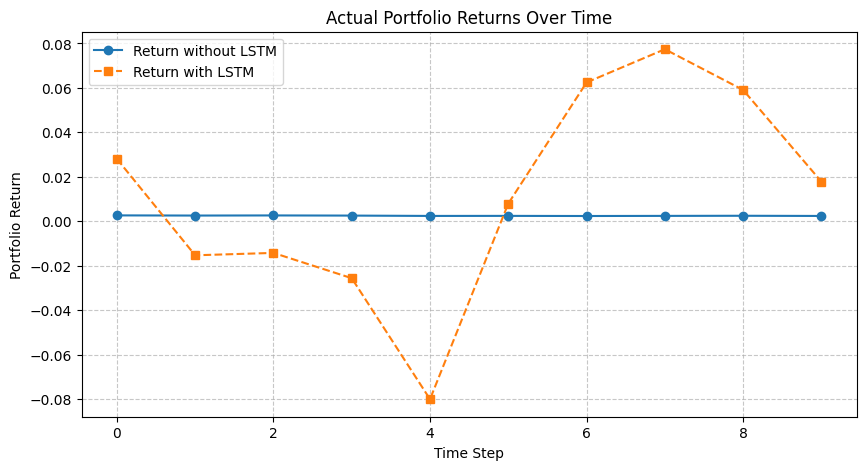

In [58]:
import matplotlib.pyplot as plt

# ÂÅáËÆæ actual_portfolio_return1 Âíå actual_portfolio_return2 Â∑≤ÁªèËÆ°ÁÆóÂ•Ω
plt.figure(figsize=(10, 5))

# ÁªòÂà∂ÂÆûÈôÖÊî∂ÁõäÊõ≤Á∫ø
plt.plot(actual_portfolio_return1, label="Return without LSTM", marker='o', linestyle='-')
plt.plot(actual_portfolio_return2, label="Return with LSTM", marker='s', linestyle='--')

# Ê∑ªÂä†Ê†áÈ¢òÂíåÊ†áÁ≠æ
plt.xlabel("Time Step")
plt.ylabel("Portfolio Return")
plt.title("Actual Portfolio Returns Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# ÊòæÁ§∫ÂõæË°®
plt.show()


In [47]:
actual_portfolio_return1

[-0.0006447191248090955,
 -0.000622285116908261,
 -0.0006156035281524586,
 -0.0005363461102101119,
 -0.0004911176552872265,
 -0.0003977921931047901,
 -0.0006127543440945793,
 -0.0005604219585027548,
 -0.0005912623932183281,
 -0.000561143999375624]

In [59]:
W1[-1].value

array([[-1.00000361],
       [ 0.99999681],
       [ 0.8507805 ],
       [-1.00000744],
       [-0.99999797],
       [-0.85076493],
       [ 0.99999838],
       [ 0.99999828]])

In [60]:
W2[-1].value

array([[ 0.86429004],
       [-0.99999845],
       [ 1.00000097],
       [-0.99999956],
       [-0.99999745],
       [-0.8642969 ],
       [ 1.00000129],
       [ 1.00000005]])